In [1]:
import pandas as pd
import re, math
import seaborn as sns
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
from pprint import pprint

pd.options.display.float_format = "{:,.2f}".format

sns.set_theme(style='whitegrid')

# Config Session

In [2]:
PATH_RULES = 'data/rules.json'

PROTEINS = {
    1: 'CARNES',
    2: 'CARNES ULTRAPROCESSADAS',
    3: 'PESCADOS',
    4: 'OVOS',
    5: 'SUBSTITUTOS DE CARNE'
}

CODES = {
    11: 'CARNE BOVINA',
    12: 'CARNE SUINA',
    13: 'OUTRAS CARNES',
    14: 'AVES',
    15: 'CARNES SECAS E SALGADAS',
    16: 'VÍSCERAS',
    17: 'PREPARAÇÕES QUE INCLUEM CARNES BOVINAS',
    17: 'PREPARAÇÕES QUE INCLUEM OUTRAS CARNES',
    21: 'ALMÔNDEGAS, HAMBURGERS E NUGGETS',
    22: 'EMBUTIDOS, FRIOS E CONSERVAS',
    23: 'PREPARAÇÕES QUE INCLUEM CARNES UP',	
    31: 'PESCADOS FRESCOS',
    32: 'PESCADOS EM CONSERVA',
    33: 'PESCADOS SALGADOS',
    34: 'PREPARAÇÕES QUE INCLUEM PESCADOS',
    41: 'OVOS INTEIROS',
    42: 'REFEIÇÕES QUE INCLUEM OVOS',
    51: 'PTS - CARNE DE SOJA',
    52: 'PREPARAÇÕES QUE INCLUEM CARNE DE SOJA'
}

CORTES = {
    111: 'CORTE TRASEIRO',
    112: 'CORTE DIANTEIRO'
}

VIS_FIELDS = [
    'ano',
	'item',
	'un',
	'qt',
	'valor_un',
	'valor',
	'valor_real',
	'produtos',
	'un_adj',
    #'is_outlier_valor_un',
    #'is_outlier_qt',
    #'quartile_range_valor_un',
    #'quartile_range_qt'
]



# Input Data

In [3]:
df_units_products = pd.read_csv('data/stat_unidades_por_produto.csv')
df_dataset_beef = pd.read_parquet('data/banco_carnes_un_v2.parquet')
df_valores_carne = pd.read_excel('data/valores_medios_ano.xlsx')
df_valores_carne_f = pd.read_csv('data/valores_medios_ano_filled.csv')

df_dataset_beef['has_change'] = 0
df_dataset_beef['unit_kg'] = 0
df_dataset_beef['price_kg'] = 0
df_dataset_beef['rule_apply'] = 0
df_dataset_beef['outlier'] = 0


with open(PATH_RULES, 'r') as f: rules = json.load(f)

# Helpers

In [4]:

def set_outlier_property(df, col):
    def classify_quartile(value, q1, q3):
        q1_q2 = (q1 + q3) / 2
        if value <= q1:
            return f'Q1 (<= {q1:.1f})'
        elif q1 < value <= q1_q2:
            return f'Q1-Q2 ({q1:.1f} - {q1_q2:.1f})'
        elif q1_q2 < value <= q3:
            return f'Q3-Q4 ({q1_q2:.1f} - {q3:.1f})'
        else:
            return f'Q4 (> {q3:.1f})'

    q1 = df[col].quantile(0.10)
    q3 = df[col].quantile(0.95)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df[f'is_outlier_{col}'] = (~df[col].between(lower_bound, upper_bound)).astype(int)
  
    df[f'quartile_range_{col}'] = df[col].apply(lambda x: classify_quartile(x, q1, q3))
    return df

# Detect outliers

In [5]:

# these values will be changed (calculated)
df_dataset_beef.loc[
    (df_dataset_beef['valor_un'].isna()) & 
    (df_dataset_beef['qt'] >= 1) &
    (df_dataset_beef['codigo'] == 41) &
    (df_dataset_beef['un_adj'] == 'DZ'),
    'has_change'
] = 1

# fix nan values in valor_un
df_dataset_beef.loc[
    (df_dataset_beef['valor_un'].isna()) & 
    (df_dataset_beef['qt'] >= 1) &
    (df_dataset_beef['codigo'] == 41) &
    (df_dataset_beef['un_adj'] == 'DZ'),
    'valor_un'
] = df_dataset_beef['valor'].div(df_dataset_beef['qt'])




In [10]:
df_dataset_beef = df_dataset_beef.fillna(0)

In [13]:


# detect firsts outliers for qt and valor_un
df_dataset_beef_cls = df_dataset_beef.groupby(['produtos', 'un_adj'], group_keys=False)\
    .apply(lambda group: set_outlier_property(group, 'valor_un'))

df_dataset_beef_cls = df_dataset_beef_cls.groupby(['produtos', 'un_adj'], group_keys=False)\
    .apply(lambda group: set_outlier_property(group, 'qt'))

# Checking records

In [14]:
# Filtrar os dados com um único filtro consistente
filtered_data = df_dataset_beef_cls.query('codigo == 41 and un_adj != "-" and un_adj == "DZ"')
total = len(filtered_data)  # Total de registros no filtro

# Groupby com cálculos ajustados
result = (
    filtered_data
    .groupby(['un_adj', 'quartile_range_valor_un', 'is_outlier_valor_un'])
    .agg(
        count=('valor_un', 'count'),
        q1=('valor_un', lambda x: x.quantile(0.25)),  # 1º quartil
        q2=('valor_un', 'median'),  # Mediana (2º quartil)
        q3=('valor_un', lambda x: x.quantile(0.75)),  # 3º quartil
        min=('valor_un', 'min'),  # Valor mínimo
        max=('valor_un', 'max'),  # Valor máximo
    )
    .reset_index()
)

result['count_percent'] = result['count'].div(result['count'].sum())

result

,un_adj,quartile_range_valor_un,is_outlier_valor_un,count,q1,q2,q3,min,max,count_percent
0,DZ,Q1 (<= 3.1),0,82518,2.50,2.85,3.00,0.00,3.09,0.10
1,DZ,Q1-Q2 (3.1 - 6.2),0,600038,3.80,4.31,5.00,3.09,6.17,0.73
2,DZ,Q3-Q4 (6.2 - 9.3),0,100132,6.60,7.13,8.00,6.18,9.25,0.12
3,DZ,Q4 (> 9.3),0,35067,10.00,11.00,12.60,9.25,18.49,0.04
4,DZ,Q4 (> 9.3),1,6128,38.00,78.00,114.00,18.50,"12,014.45",0.01


# Add Reference Values from Auxiliary
This code section adds a column containing the reference values verified by the team.

In [15]:
df_dataset_beef_cls['valor_un_ref'] = 0
from unidecode import unidecode

ref_names = [
    'CARNE BOVINA',
    'ACEM', 
    'CHARQUE PA',
    'COSTELA',
    'PONTA DE AGULHA',
	'OVO'
    #'QUARTO DIANTEIRO COM OSSO',
    #'QUARTO TRASEIRO COM OSSO'
]

# "corte" significa corte traseiro (=111) ou dianteiro (=112)

for ref_name in ref_names:
	for year in list(range(2014, 2023)):

		ref_val = df_valores_carne_f.loc[
			df_valores_carne_f['item'].str.contains('ACÉM' if ref_name == 'ACEM' else ref_name, na=False, case=False)
		][f'valor_{str(year)}'].values[0]

		df_dataset_beef_cls.loc[
			(df_dataset_beef_cls['ano'] == year) &
			(df_dataset_beef_cls['item'].str.contains(ref_name, na=False, case=False)),
			'valor_un_ref'
		] = ref_val




# Applying Rules

In [16]:
# iterate over rules by products
for k, v in rules.items():

	# get rule dict
	for rule in v:
		filter_condition = rule['filter']
		unit_kg_expression = rule['unit_kg']	

		filtered_rows = df_dataset_beef_cls.query(filter_condition)
		df_dataset_beef_cls.loc[filtered_rows.index, 'unit_kg'] = filtered_rows.eval(unit_kg_expression)


	# calculate price/kg
	df_dataset_beef_cls.loc[
		(df_dataset_beef_cls['codigo'] == int(k)) &
		(df_dataset_beef_cls['unit_kg'] != 0),
		'price_kg'
	] = df_dataset_beef_cls['valor'].div(df_dataset_beef_cls['unit_kg'])



# check if rule was applied
df_dataset_beef_cls.loc[
	df_dataset_beef_cls['unit_kg'] != 0,
	'rule_apply'
] = 1


In [17]:
df_dataset_beef_cls.loc[
	(df_dataset_beef_cls['codigo'] == 41) &
    (df_dataset_beef_cls['rule_apply'] == 0)
][VIS_FIELDS + ['price_kg']].sort_values('price_kg', ascending=False)

,ano,item,un,qt,valor_un,valor,valor_real,produtos,un_adj,price_kg
74,2013,OVO DE GALINHA,DZ,40.00,2.99,119.60,224.20,OVOS INTEIROS,DZ,0.00
5464345,2018,OVOS,KG,9.00,6.50,58.50,79.92,OVOS INTEIROS,KG,0.00
5463953,2018,OVOS VERMELHOS EM BANDEJA ****,BDJ ****,130.00,4.77,620.10,872.73,OVOS INTEIROS,BANDEJA,0.00
5463954,2018,OVOS VERMELHOS EM BANDEJA ****,BDJ ****,100.00,4.77,477.00,671.33,OVOS INTEIROS,BANDEJA,0.00
5463955,2018,OVOS VERMELHOS EM BANDEJA,BDJ ****,108.00,4.77,515.16,725.04,OVOS INTEIROS,BANDEJA,0.00
...,...,...,...,...,...,...,...,...,...,...
1954762,2014,OVO DE GALINHA,DZ,8.00,3.00,24.00,42.24,OVOS INTEIROS,DZ,0.00
1954763,2014,OVO DE GALINHA,DZ,26.00,3.00,78.00,137.29,OVOS INTEIROS,DZ,0.00
1954764,2014,OVO DE GALINHA,DZ,15.00,3.00,45.00,79.20,OVOS INTEIROS,DZ,0.00
1954765,2014,OVO DE GALINHA,DZ,17.00,3.00,51.00,89.77,OVOS INTEIROS,DZ,0.00


Text(0, 0.5, 'Preço/Kg (R$)')

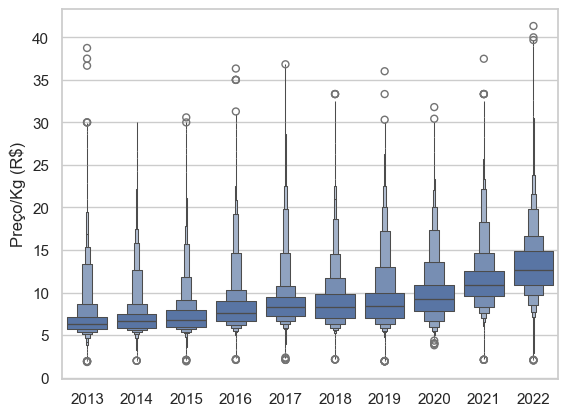

In [19]:
sns.boxenplot(data=df_dataset_beef_cls.loc[
	(df_dataset_beef_cls['codigo'] == 41) &
    (df_dataset_beef_cls['rule_apply'] == 1) 
], x="ano", y="price_kg")

plt.xlabel('')
plt.ylabel('Preço/Kg (R$)')

# Export Dataset

In [20]:
df_dataset_beef_cls.loc[
	(df_dataset_beef_cls['codigo'] == 41) &
    (df_dataset_beef_cls['price_kg'] > 25),
    'outlier'
] = 1

df_dataset_beef_cls.loc[
	(df_dataset_beef_cls['codigo'] == 11) &
    (df_dataset_beef_cls['price_kg'] > 60),
    'outlier'
] = 1


In [21]:
df_dataset_beef_cls['produtos'] = df_dataset_beef_cls['produtos'].astype(str)
df_dataset_beef_cls['dados.CNPJ.CPF'] = df_dataset_beef_cls['dados.CNPJ.CPF'].astype(str)
df_dataset_beef_cls['dados.emissao'] = df_dataset_beef_cls['dados.emissao'].astype(str)
df_dataset_beef_cls['un'] = df_dataset_beef_cls['un'].astype(str)

# drop fields
df_dataset_beef_cls.drop(['is_outlier_valor_un','quartile_range_valor_un','is_outlier_qt','quartile_range_qt'],axis=1,inplace=True)

df_dataset_beef_cls.to_parquet('data/banco_carnes_un_v2_ed.parquet')

# Compute Stat

In [22]:
df_stat_rule = df_dataset_beef_cls.groupby(['produtos','rule_apply']).agg(
    count=('rule_apply', 'count')
).reset_index()



df_stat_rule['percent'] = df_stat_rule['count'] / df_stat_rule.groupby('produtos')['count'].transform('sum') * 100
df_stat_rule.to_csv('data/stat_rule_apply.csv')

df_stat_rule

,produtos,rule_apply,count,percent
0,0,0,14274,100.00
1,"ALMÔNDEGAS, HAMBURGERS E NUGGETS",0,57650,100.00
2,AVES,0,1846912,100.00
3,CARNE BOVINA,0,62039,2.75
4,CARNE BOVINA,1,2196582,97.25
5,CARNE SUINA,0,261493,100.00
6,CARNES SECAS E SALGADAS,0,360352,100.00
7,"EMBUTIDOS, FRIOS E CONSERVAS",0,886284,100.00
8,OUTRAS CARNES,0,13398,100.00
9,OVOS INTEIROS,0,194013,16.95


In [23]:
df_dataset_beef_cls.loc[
    (df_dataset_beef_cls['codigo'] == 41) & (df_dataset_beef_cls['rule_apply'] == 1)
].groupby('outlier').count()

,...1,ano,UF,municipio,dados.fornecedor,dados.CNPJ.CPF,dados.tipo,dados.n_doc,dados.emissao,valor_total_nota_fiscal,...,valor_real,cluster,valor_real_USD,produtos,un_adj,has_change,unit_kg,price_kg,rule_apply,valor_un_ref
outlier,,,,,,,,,,,,,,,,,,,,,
0,947773,947773,947773,947773,947773,947773,947773,947773,947773,947773,...,947773,947773,947773,947773,947773,947773,947773,947773,947773,947773
1,2743,2743,2743,2743,2743,2743,2743,2743,2743,2743,...,2743,2743,2743,2743,2743,2743,2743,2743,2743,2743
